# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import lightgbm as lgb

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)

plt.style.use('seaborn-white')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_20/2166621579.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## The Dataset

Stroke Prediction Data. Using information about patients, predict if thet are likely to have a stroke.

* Gender, martial status, smoking status, age, etc.
* Also have a "Doctor" feature added to represent the "group" within the data.

In [2]:
def get_prep_data():
    data = pd.read_csv(
        "../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv"
    )
    data["ever_married"] = (
        data["ever_married"].replace("Yes", True).replace("No", False)
    )
    data["gender"] = data["gender"].astype("category")
    data["smoking_status"] = data["smoking_status"].astype("category")
    data["Residence_type"] = data["Residence_type"].astype("category")
    data["work_type"] = data["work_type"].astype("category")
    data["doctor"] = np.random.randint(0, 8, size=len(data))
    holdout_ids = data.sample(n=500, random_state=529).index

    train = (
        data.loc[~data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )
    holdout = (
        data.loc[data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )

    return train, holdout


train, holdout = get_prep_data()

In [3]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,37698,Female,15.0,0,0,False,children,Urban,87.96,21.5,formerly smoked,0,0
1,72231,Female,47.0,0,0,True,Self-employed,Rural,195.61,NaN,never smoked,0,0
2,507,Female,28.0,0,0,True,Private,Rural,94.15,23.1,smokes,0,0
3,46483,Male,23.0,0,0,False,Private,Urban,77.75,38.8,smokes,0,0
4,20890,Female,61.0,0,0,True,Private,Rural,79.89,24.5,smokes,0,0


In [4]:
train.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'doctor'],
      dtype='object')

In [5]:
FEATURES = [
    "gender",
    "age",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "avg_glucose_level",
    "bmi",
    "smoking_status",
]
GROUPS = "doctor"

TARGET = "stroke"

In [6]:
def get_X_y(train):
    FEATURES = [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "ever_married",
        "work_type",
        "Residence_type",
        "avg_glucose_level",
        "bmi",
        "smoking_status",
    ]

    GROUPS = "doctor"

    TARGET = "stroke"

    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    return X, y, groups

In [7]:
X, y, groups = get_X_y(train)
clf = lgb.LGBMClassifier(n_estimators=100)
clf.fit(X,y)
# Predict on training set
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)[:, 1]

In [8]:
acc_score = accuracy_score(y, pred)
# Area under the curve is another way to evaluate binary predictions but with feeding the prob.
auc_score = roc_auc_score(y, pred_prob)

print(f'The score on the trainingh set is accuracy: {acc_score:0.4f} and AUC of {auc_score:0.4f}')

The score on the trainingh set is accuracy: 0.9911 and AUC of 0.9997


# Model can predict with 99% accuracy!!!
* NOPE!

In [9]:
X_holdout = holdout[FEATURES]
y_holdout = holdout[TARGET]

pred = clf.predict(X_holdout)
pred_prob = clf.predict_proba(X_holdout)[:, 1]
acc_score = accuracy_score(y_holdout, pred)
# Area under the curve is another way to evaluate ginarty predictions but with feeding the prob.
auc_score = roc_auc_score(y_holdout, pred_prob)
print(f'Our accuracy on the holdout set is {acc_score:0.4f} and AUC is {auc_score:0.4f}')

Our accuracy on the holdout set is 0.9380 and AUC is 0.7802


## Baseline
Predicting all zeros

In [10]:
accuracy_score(y, np.zeros_like(y)), roc_auc_score(y, np.zeros_like(y))

(0.9516268980477224, 0.5)

## Train/Test Split

Split the training data into a training and validation set. Train the model on the training set, and validate it on the validation set.

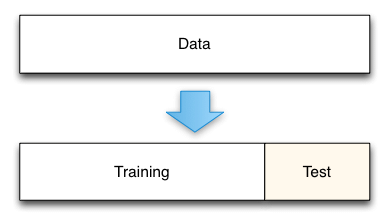

* The most basic way of splitting data.
* shuffle - Good idea to use to make sure the order isn't impacting your split.
* stratified (even distribution of positive samples in each set). Consider using if you have a small or unbalanced dataset.

In [11]:
X, y, groups = get_X_y(train)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
clf = lgb.LGBMClassifier(n_estimators=100, max_depth=3)
clf.fit(X_train,y_train)
pred = clf.predict(X_val)
pred_prob = clf.predict_proba(X_val)[:, 1]
acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_prob)
print(f'Our accuracy on the validation set is {acc_score:0.4f} and AUC is {auc_score:0.4f}')

Our accuracy on the validation set is 0.9349 and AUC is 0.8445


# Cross Validation!

In [12]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

# KFold

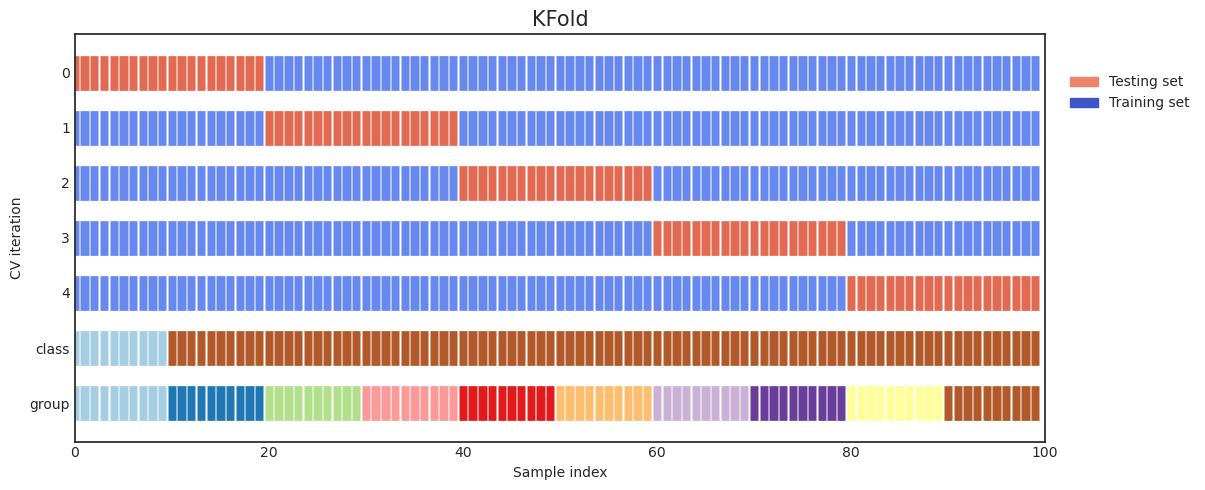

In [13]:
kf = KFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

## Stratified KFold

* KFold but the folds are made by preserving the percentage of samples for each class.

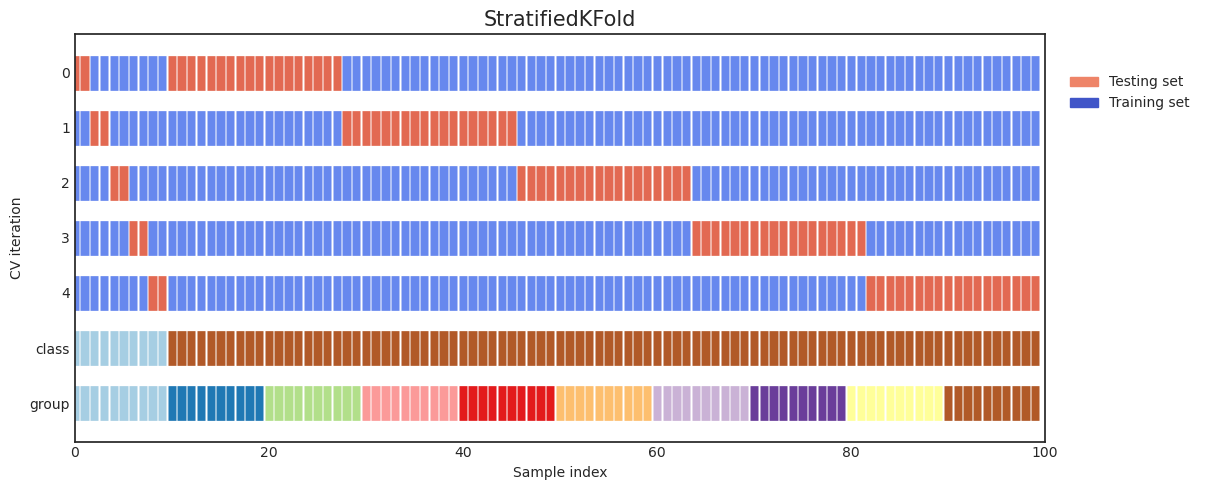

In [14]:
strkf = StratifiedKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

# Group KFold

* The Folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

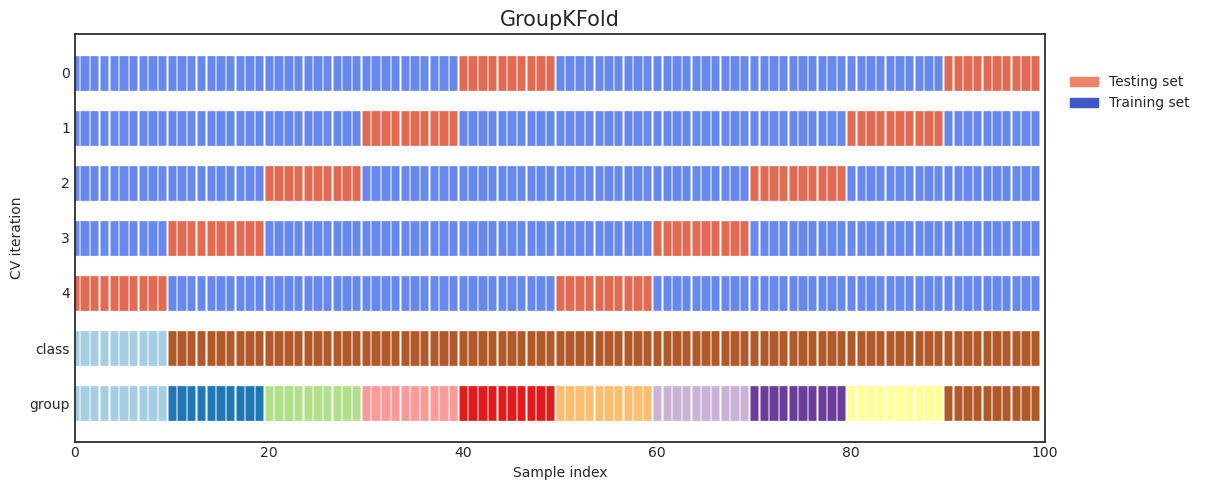

In [15]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

# Stratified Group KFold

* The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to create folds which preserve the percentage of samples for each class as much as possible given the constraint of non-overlapping groups between splits.

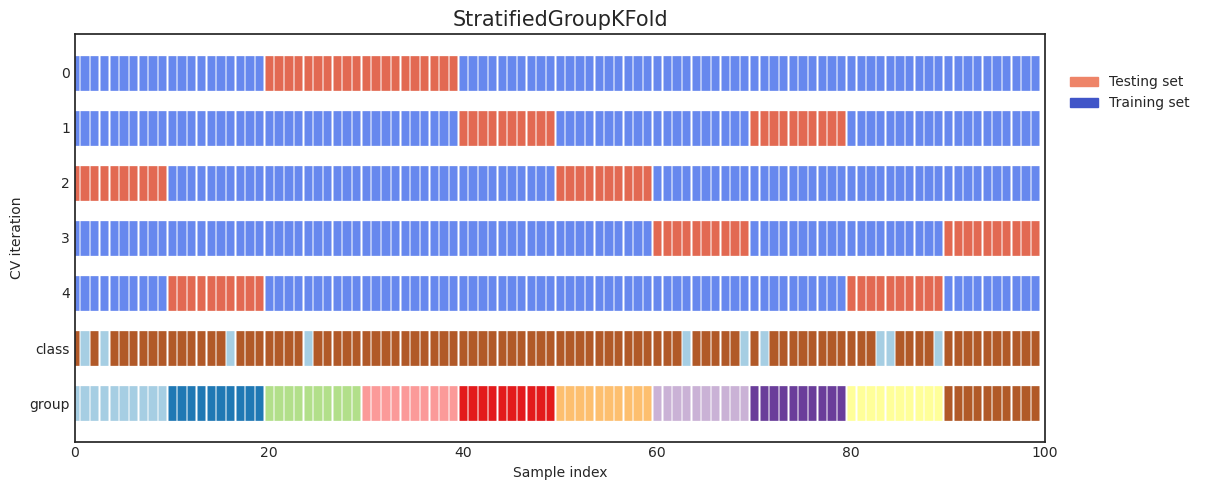

In [16]:
strgkf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

# Time Series Split

* TimeSeriesSplit is a variation of k-fold which returns first folds as train set and the fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.

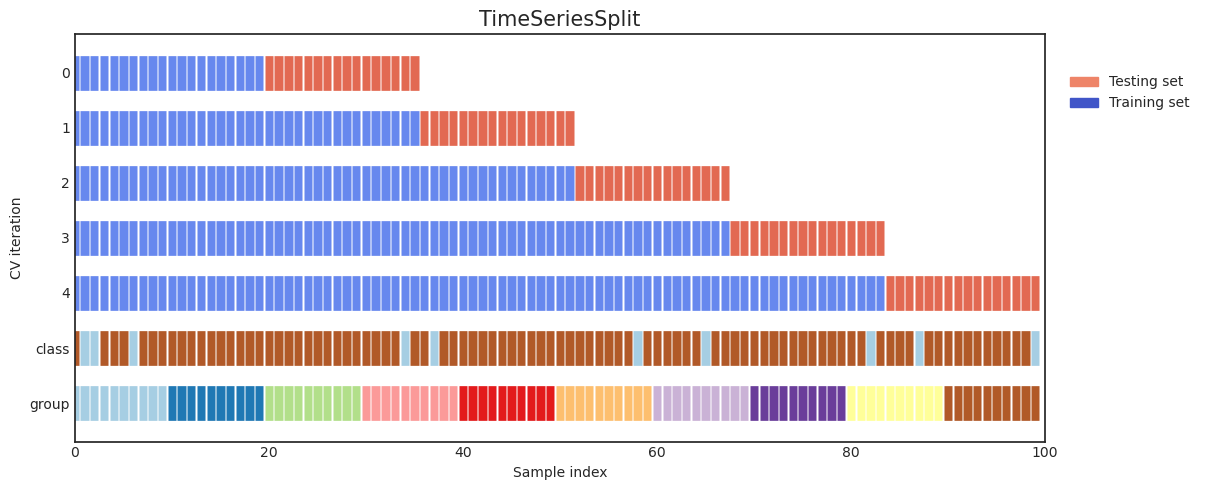

In [17]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)

# Our Example Using Proper Cross Validation
1. Small/imbalanced -> Stratified
2. Group
3. Shuffle is on

`StratifiedGroupKFold`

In [18]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)

X, y, groups = get_X_y(train)

fold = 0
aucs = []
for train_idx, val_idx in sgk.split(X, y, groups):
    break

In [19]:
train_idx

array([   0,    1,    2, ..., 4607, 4608, 4609])

In [20]:
val_idx

array([1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720,
       1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731,
       1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742,
       1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753,
       1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764,
       1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775,
       1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786,
       1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797,
       1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808,
       1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819,
       1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830,
       1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841,
       1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852,
       1853, 1854, 1855, 1856, 1857, 1858, 1859, 18

In [21]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)

X, y, groups = get_X_y(train)

fold = 0
aucs = []
for train_idx, val_idx in sgk.split(X, y, groups):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]
    
    # Fit Model on Train
    clf = lgb.LGBMClassifier(n_estimators=100)
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_val)
    pred_prob = clf.predict_proba(X_val)[:, 1]
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    print(f'====== Fold {fold} ======')
    print(f'Our accuracy on the validation set is {acc_score:0.4f} and AUC is {auc_score:0.4f}')
    fold += 1
    aucs.append(auc_score)
oof_auc = np.mean(aucs)
print(f'Our out of fold AUC score is {oof_auc:0.4f}')

====== Fold 0 ======
Our accuracy on the validation set is 0.9434 and AUC is 0.8099
====== Fold 1 ======
Our accuracy on the validation set is 0.9456 and AUC is 0.8366
====== Fold 2 ======
Our accuracy on the validation set is 0.9503 and AUC is 0.8220
====== Fold 3 ======
Our accuracy on the validation set is 0.9567 and AUC is 0.8591
====== Fold 4 ======
Our accuracy on the validation set is 0.9466 and AUC is 0.8260
Our out of fold AUC score is 0.8307
